# Audio Autoencoder (RNN Version)

## Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import OrderedDict
import torchaudio
import simpleaudio as sa
import numpy as np
import glob
from matplotlib import pyplot as plt
import os, time
import json
import csv
import re

from vocos import Vocos

import IPython
from IPython.display import display
import ipywidgets as widgets

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Settings

## Compute Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Audio Settings

In [3]:
audio_file_path = "../../../Data/sounds/"
audio_files = ["Night_and_Day_by_Virginia_Woolf_48khz.wav"]
audio_sample_rate = 48000 # numer of audio samples per sec
audio_channel_count = 1
audio_window_length = 2048 # this results in 9 mel spectra

audio_file_path_gui = widgets.Text(value=audio_file_path, description="Audio File Path:", style={'description_width': 'initial'}) 

audio_files_gui = widgets.Textarea(
    value=','.join(audio_files),
    placeholder='Enter file names separated by commas',
    description='Audio Files:',
    layout=widgets.Layout(width='50%')
)

audio_sample_rate_gui = widgets.IntText(value=audio_sample_rate, description="Audio Sample Rate:", style={'description_width': 'initial'})
audio_channel_count_gui = widgets.IntText(value=audio_channel_count, description="Audio Channel Count:", style={'description_width': 'initial'})
audio_window_length_gui = widgets.IntText(value=audio_window_length, description="Audio Window Length:", style={'description_width': 'initial'})

display(audio_file_path_gui)
display(audio_files_gui)
display(audio_sample_rate_gui)
display(audio_channel_count_gui)
display(audio_window_length_gui)

Text(value='../../../Data/sounds/', description='Audio File Path:', style=TextStyle(description_width='initial…

Textarea(value='Night_and_Day_by_Virginia_Woolf_48khz.wav', description='Audio Files:', layout=Layout(width='5…

IntText(value=48000, description='Audio Sample Rate:', style=DescriptionStyle(description_width='initial'))

IntText(value=1, description='Audio Channel Count:', style=DescriptionStyle(description_width='initial'))

IntText(value=2048, description='Audio Window Length:', style=DescriptionStyle(description_width='initial'))

In [4]:
audio_file_path = audio_file_path_gui.value
audio_files = re.split(r'\s*,\s*', audio_files_gui.value)
audio_sample_rate = audio_sample_rate_gui.value
audio_channel_count = audio_channel_count_gui.value
audio_window_length = audio_window_length_gui.value

## Autoencoder Settings

In [22]:
latent_dim = 32
sequence_length = None # will be calculate automatically
ae_rnn_layer_count = 2
ae_rnn_layer_size = 512
ae_dense_layer_sizes = [ 512 ]

save_weights = True
load_weights = False
encoder_weights_file = "results/weights/encoder_weights_epoch_400"
decoder_weights_file = "results/weights/decoder_weights_epoch_400"

latent_dim_gui = widgets.IntText(value=latent_dim, description="Latent Dimension:", style={'description_width': 'initial'})
ae_rnn_layer_count_gui = widgets.IntText(value=ae_rnn_layer_count, description="LSTM Layer Count:", style={'description_width': 'initial'})
ae_rnn_layer_size_gui = widgets.IntText(value=ae_rnn_layer_size, description="LSTM Layer Size:", style={'description_width': 'initial'})

ae_dense_layer_sizes_gui = widgets.Textarea(
    value=','.join(list(map(str, ae_dense_layer_sizes))),
    placeholder='Enter dense layer sizes separated by commas',
    description='Dense Layer Sizes:',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

save_weights_gui = widgets.Checkbox(
    value=save_weights,
    description='Save Weights',
    disabled=False,
    style={'description_width': 'initial'}
)

load_weights_gui = widgets.Checkbox(
    value=load_weights,
    description='Load Weights',
    disabled=False,
    style={'description_width': 'initial'}
)

encoder_weights_file_gui = widgets.Text(value=encoder_weights_file, description="Encoder Weights File:", style={'description_width': 'initial'}) 
decoder_weights_file_gui = widgets.Text(value=decoder_weights_file, description="Decoder Weights File:", style={'description_width': 'initial'}) 

display(latent_dim_gui)
display(ae_rnn_layer_count_gui)
display(ae_rnn_layer_size_gui)
display(ae_dense_layer_sizes_gui)
display(save_weights_gui)
display(load_weights_gui)
display(encoder_weights_file_gui)
display(decoder_weights_file_gui)

IntText(value=32, description='Latent Dimension:', style=DescriptionStyle(description_width='initial'))

IntText(value=2, description='LSTM Layer Count:', style=DescriptionStyle(description_width='initial'))

IntText(value=512, description='LSTM Layer Size:', style=DescriptionStyle(description_width='initial'))

Textarea(value='512', description='Dense Layer Sizes:', layout=Layout(width='50%'), placeholder='Enter dense l…

Text(value='results/weights/encoder_weights_epoch_400', description='Encoder Weights File:', style=TextStyle(d…

Text(value='results/weights/decoder_weights_epoch_400', description='Decoder Weights File:', style=TextStyle(d…

In [7]:
latent_dim = latent_dim_gui.value
ae_rnn_layer_count = ae_rnn_layer_count_gui.value
ae_rnn_layer_size = ae_rnn_layer_size_gui.value
ae_dense_layer_sizes  = [int(s) for s in re.split(r"\s*,\s*", ae_dense_layer_sizes_gui.value) if s.strip()]
save_weights = save_weights_gui.value
load_weights = load_weights_gui.value
encoder_weights_file = encoder_weights_file_gui.value
decoder_weights_file = decoder_weights_file_gui.value

## Training Settings

In [8]:
data_count = 100000
batch_size = 32

ae_learning_rate = 1e-4
ae_rec_loss_scale = 5.0
ae_beta = 0.0 # will be calculated
ae_beta_cycle_duration = 100
ae_beta_min_const_duration = 20
ae_beta_max_const_duration = 20
ae_min_beta = 0.0
ae_max_beta = 0.1

epochs = 400
model_save_interval = 50
save_history = True

data_count_gui = widgets.IntText(value=data_count, description="Dataset Size:", style={'description_width': 'initial'})
batch_size_gui = widgets.IntText(value=batch_size, description="Batch Size:", style={'description_width': 'initial'})
ae_learning_rate_gui = widgets.FloatText(value=ae_learning_rate, description="Autoencoder Learning Rate:", style={'description_width': 'initial'})
ae_rec_loss_scale_gui = widgets.FloatText(value=ae_rec_loss_scale, description="Autoencoder Reconstruction Loss Scale:", style={'description_width': 'initial'})
ae_min_beta_gui = widgets.FloatText(value=ae_min_beta, description="Minimum Beta Factor:", style={'description_width': 'initial'})
ae_max_beta_gui = widgets.FloatText(value=ae_max_beta, description="Maximum Beta Factor:", style={'description_width': 'initial'})
ae_beta_cycle_duration_gui = widgets.IntText(value=ae_beta_cycle_duration, description="Cycle Duration for Beta Factor:", style={'description_width': 'initial'})
ae_beta_min_const_duration_gui = widgets.IntText(value=ae_beta_min_const_duration, description="Duration for Minimum Beta Factor:", style={'description_width': 'initial'})
ae_beta_max_const_duration_gui = widgets.IntText(value=ae_beta_min_const_duration, description="Duration for Maximum Beta Factor:", style={'description_width': 'initial'})
epochs_gui = widgets.IntText(value=epochs, description="Number of Training Epochs:", style={'description_width': 'initial'})
model_save_interval_gui = widgets.IntText(value=model_save_interval, description="Model Save Interval:", style={'description_width': 'initial'})

save_history_gui = widgets.Checkbox(
    value=save_history,
    description='Save Training History',
    disabled=False,
    style={'description_width': 'initial'}
)

display(data_count_gui)
display(batch_size_gui)
display(ae_learning_rate_gui)
display(ae_rec_loss_scale_gui)
display(ae_min_beta_gui)
display(ae_max_beta_gui)
display(ae_beta_cycle_duration_gui)
display(ae_beta_min_const_duration_gui)
display(ae_beta_max_const_duration_gui)
display(epochs_gui)
display(model_save_interval_gui)

IntText(value=100000, description='Dataset Size:', style=DescriptionStyle(description_width='initial'))

IntText(value=32, description='Batch Size:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0001, description='Autoencoder Learning Rate:', style=DescriptionStyle(description_width='in…

FloatText(value=5.0, description='Autoencoder Reconstruction Loss Scale:', style=DescriptionStyle(description_…

FloatText(value=0.0, description='Minimum Beta Factor:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.1, description='Maximum Beta Factor:', style=DescriptionStyle(description_width='initial'))

IntText(value=100, description='Cycle Duration for Beta Factor:', style=DescriptionStyle(description_width='in…

IntText(value=20, description='Duration for Minimum Beta Factor:', style=DescriptionStyle(description_width='i…

IntText(value=20, description='Duration for Maximum Beta Factor:', style=DescriptionStyle(description_width='i…

IntText(value=400, description='Number of Training Epochs:', style=DescriptionStyle(description_width='initial…

IntText(value=50, description='Model Save Interval:', style=DescriptionStyle(description_width='initial'))

In [9]:
data_count = data_count_gui.value
batch_size = batch_size_gui.value
ae_learning_rate = ae_learning_rate_gui.value
ae_rec_loss_scale = ae_rec_loss_scale_gui.value
ae_beta_cycle_duration = ae_beta_cycle_duration_gui.value
ae_beta_min_const_duration = ae_beta_min_const_duration_gui.value
ae_beta_max_const_duration = ae_beta_max_const_duration_gui.value
ae_min_beta = ae_min_beta_gui.value
ae_max_beta = ae_max_beta_gui.value
epochs = epochs_gui.value
model_save_interval = model_save_interval_gui.value
save_history = save_history_gui.value

## Create Vocoder Model

In [10]:
vocos = Vocos.from_pretrained("kittn/vocos-mel-48khz-alpha1").to(device)

## Determine Number of Mel Filters and Mel Spectra

In [11]:
vocoder_features = vocos.feature_extractor(torch.rand(size=(1, audio_window_length), dtype=torch.float32).to(device))
mel_count = vocoder_features.shape[-1]
mel_filter_count = vocoder_features.shape[1]
sequence_length = mel_count

print("audio_window_length ", audio_window_length, " mel_count ", mel_count, " mel_filter_count ", mel_filter_count)

audio_window_length  2048  mel_count  9  mel_filter_count  128


## Create Dataset

In [12]:
class AudioDataset(Dataset):
    def __init__(self, audio_file_path, audio_files, audio_window_length, audio_data_count):
        self.audio_file_path = audio_file_path
        self.audio_files = audio_files
        self.audio_window_length = audio_window_length
        self.audio_data_count = audio_data_count
        
        self.audio_waveforms = []
        
        for audio_file in self.audio_files:
            audio_waveform, _ = torchaudio.load(self.audio_file_path + "/" + audio_file)
            self.audio_waveforms.append(audio_waveform)
    
    def __len__(self):
        return self.audio_data_count
    
    def __getitem__(self, idx):
        
        audio_index = torch.randint(0, len(self.audio_waveforms), size=(1,))
        audio_waveform = self.audio_waveforms[audio_index]
        
        audio_length = audio_waveform.shape[1]
        audio_excerpt_start = torch.randint(0, audio_length - self.audio_window_length, size=(1,))
        audio_excerpt = audio_waveform[:, audio_excerpt_start:audio_excerpt_start+audio_window_length]
        audio_excerpt = audio_excerpt[0]
        
        return audio_excerpt


full_dataset = AudioDataset(audio_file_path, audio_files, audio_window_length, data_count)
dataset_size = len(full_dataset)

data_item = full_dataset[0]

print("data_item s ", data_item.shape)

dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

batch_x = next(iter(dataloader))

print("batch_x s ", batch_x.shape)

data_item s  torch.Size([2048])
batch_x s  torch.Size([32, 2048])


## Create Models

## Create Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, sequence_length, mel_filter_count, latent_dim, rnn_layer_count, rnn_layer_size, dense_layer_sizes):
        super(Encoder, self).__init__()
        
        self.sequence_length = sequence_length
        self.mel_filter_count = mel_filter_count
        self.latent_dim = latent_dim
        self.rnn_layer_count = rnn_layer_count
        self.rnn_layer_size = rnn_layer_size 
        self.dense_layer_sizes = dense_layer_sizes
    
        # create recurrent layers
        rnn_layers = []
        rnn_layers.append(("encoder_rnn_0", nn.LSTM(self.mel_filter_count, self.rnn_layer_size, self.rnn_layer_count, batch_first=True)))
        
        self.rnn_layers = nn.Sequential(OrderedDict(rnn_layers))
        
        # create dense layers
        
        dense_layers = []
        
        dense_layers.append(("encoder_dense_0", nn.Linear(self.rnn_layer_size, self.dense_layer_sizes[0])))
        dense_layers.append(("encoder_dense_relu_0", nn.ReLU()))
        
        dense_layer_count = len(self.dense_layer_sizes)
        for layer_index in range(1, dense_layer_count):
            dense_layers.append(("encoder_dense_{}".format(layer_index), nn.Linear(self.dense_layer_sizes[layer_index-1], self.dense_layer_sizes[layer_index])))
            dense_layers.append(("encoder_dense_relu_{}".format(layer_index), nn.ReLU()))
            
        self.dense_layers = nn.Sequential(OrderedDict(dense_layers))
        
        # create final dense layers
            
        self.fc_mu = nn.Linear(self.dense_layer_sizes[-1], self.latent_dim)
        self.fc_std = nn.Linear(self.dense_layer_sizes[-1], self.latent_dim)
        
    def forward(self, x):
        
        #print("x 1 ", x.shape)
        
        x, (_, _) = self.rnn_layers(x)
        
        #print("x 2 ", x.shape)
        
        x = x[:, -1, :] # only last time step 
        
        #print("x 3 ", x.shape)
        
        x = self.dense_layers(x)
        
        #print("x 3 ", x.shape)
        
        mu = self.fc_mu(x)
        std = self.fc_std(x)
        
        #print("mu s ", mu.shape, " lvar s ", log_var.shape)
    
        return mu, std

    def reparameterize(self, mu, std):
        z = mu + std*torch.randn_like(std)
        return z
    
encoder = Encoder(sequence_length, mel_filter_count, latent_dim, ae_rnn_layer_count, ae_rnn_layer_size, ae_dense_layer_sizes).to(device)

print(encoder)

if load_weights and encoder_weights_file:
    encoder.load_state_dict(torch.load(encoder_weights_file, map_location=device))

# test encoder
audio_batch = next(iter(dataloader)).to(device)
audio_batch_mels = vocos.feature_extractor(audio_batch.unsqueeze(1))
audio_encoder_in = audio_batch_mels.squeeze(1).permute((0, 2, 1))
audio_encoder_out_mu, audio_encoder_out_std = encoder(audio_encoder_in)
audio_encoder_out = encoder.reparameterize(audio_encoder_out_mu, audio_encoder_out_std)

print("audio_batch s ", audio_batch.shape)
print("audio_batch_mels s ", audio_batch_mels.shape)
print("audio_encoder_in s ", audio_encoder_in.shape)
print("audio_encoder_out_mu s ", audio_encoder_out_mu.shape)
print("audio_encoder_out_std s ", audio_encoder_out_std.shape)
print("audio_encoder_out s ", audio_encoder_out.shape)

Encoder(
  (rnn_layers): Sequential(
    (encoder_rnn_0): LSTM(128, 512, num_layers=2, batch_first=True)
  )
  (dense_layers): Sequential(
    (encoder_dense_0): Linear(in_features=512, out_features=512, bias=True)
    (encoder_dense_relu_0): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_std): Linear(in_features=512, out_features=32, bias=True)
)
audio_batch s  torch.Size([32, 2048])
audio_batch_mels s  torch.Size([32, 1, 128, 9])
audio_encoder_in s  torch.Size([32, 9, 128])
audio_encoder_out_mu s  torch.Size([32, 32])
audio_encoder_out_std s  torch.Size([32, 32])
audio_encoder_out s  torch.Size([32, 32])


## Create Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self, sequence_length, mel_filter_count, latent_dim, rnn_layer_count, rnn_layer_size, dense_layer_sizes):
        super(Decoder, self).__init__()
        
        self.sequence_length = sequence_length
        self.mel_filter_count = mel_filter_count
        self.latent_dim = latent_dim
        self.rnn_layer_size = rnn_layer_size
        self.rnn_layer_count = rnn_layer_count
        self.dense_layer_sizes = dense_layer_sizes

        # create dense layers
        dense_layers = []
        
        dense_layers.append(("decoder_dense_0", nn.Linear(latent_dim, self.dense_layer_sizes[0])))
        dense_layers.append(("decoder_relu_0", nn.ReLU()))

        dense_layer_count = len(self.dense_layer_sizes)
        for layer_index in range(1, dense_layer_count):
            dense_layers.append(("decoder_dense_{}".format(layer_index), nn.Linear(self.dense_layer_sizes[layer_index-1], self.dense_layer_sizes[layer_index])))
            dense_layers.append(("decoder_dense_relu_{}".format(layer_index), nn.ReLU()))
 
        self.dense_layers = nn.Sequential(OrderedDict(dense_layers))
        
        # create rnn layers
        rnn_layers = []

        rnn_layers.append(("decoder_rnn_0", nn.LSTM(self.dense_layer_sizes[-1], self.rnn_layer_size, self.rnn_layer_count, batch_first=True)))
        
        self.rnn_layers = nn.Sequential(OrderedDict(rnn_layers))
        
        # final output dense layer
        final_layers = []
        
        final_layers.append(("decoder_dense_{}".format(dense_layer_count), nn.Linear(self.rnn_layer_size, self.mel_filter_count)))
        
        self.final_layers = nn.Sequential(OrderedDict(final_layers))
        
    def forward(self, x):
        #print("x 1 ", x.size())
        
        # dense layers
        x = self.dense_layers(x)
        #print("x 2 ", x.size())
        
        # repeat vector
        x = torch.unsqueeze(x, dim=1)
        x = x.repeat(1, sequence_length, 1)
        #print("x 3 ", x.size())
        
        # rnn layers
        x, (_, _) = self.rnn_layers(x)
        #print("x 4 ", x.size())
        
        # final time distributed dense layer
        x_reshaped = x.contiguous().view(-1, self.rnn_layer_size)  # (batch_size * sequence, input_size)
        #print("x 5 ", x_reshaped.size())
        
        yhat = self.final_layers(x_reshaped)
        #print("yhat 1 ", yhat.size())
        
        yhat = yhat.contiguous().view(-1, self.sequence_length, self.mel_filter_count)
        #print("yhat 2 ", yhat.size())

        return yhat

ae_dense_layer_sizes_reversed = ae_dense_layer_sizes.copy()
ae_dense_layer_sizes_reversed.reverse()

decoder = Decoder(sequence_length, mel_filter_count, latent_dim, ae_rnn_layer_count, ae_rnn_layer_size, ae_dense_layer_sizes_reversed).to(device)

print(decoder)

if load_weights and decoder_weights_file:
    decoder.load_state_dict(torch.load(decoder_weights_file, map_location=device))

# test decoder
audio_decoder_in = audio_encoder_out
audio_decoder_out = decoder(audio_decoder_in)
audio_features = audio_decoder_out.permute((0, 2, 1))

audio_features = audio_features.squeeze(1)
audio_batch = vocos.decode(audio_features)

print("audio_decoder_in s ", audio_decoder_in.shape)
print("audio_decoder_out s ", audio_decoder_out.shape)
print("audio_features s ", audio_features.shape)
print("audio_batch s ", audio_batch.shape)

Decoder(
  (dense_layers): Sequential(
    (decoder_dense_0): Linear(in_features=32, out_features=512, bias=True)
    (decoder_relu_0): ReLU()
  )
  (rnn_layers): Sequential(
    (decoder_rnn_0): LSTM(512, 512, num_layers=2, batch_first=True)
  )
  (final_layers): Sequential(
    (decoder_dense_1): Linear(in_features=512, out_features=128, bias=True)
  )
)
audio_decoder_in s  torch.Size([32, 32])
audio_decoder_out s  torch.Size([32, 9, 128])
audio_features s  torch.Size([32, 128, 9])
audio_batch s  torch.Size([32, 2048])


## Create Beta Factor Schedule

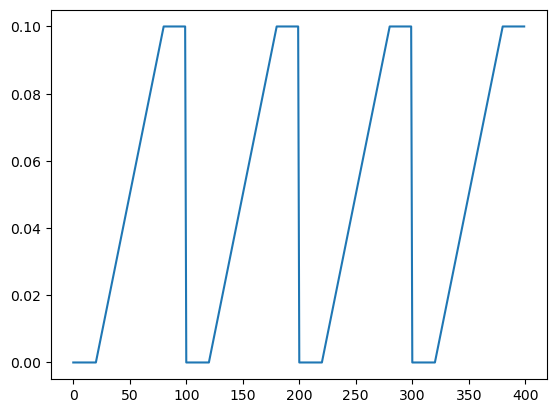

In [15]:
def calc_ae_beta_values():
    
    ae_beta_values = []

    for e in range(epochs):
        
        cycle_step = e % ae_beta_cycle_duration
        
        #print("cycle_step ", cycle_step)

        if cycle_step < ae_beta_min_const_duration:
            ae_beta_value = ae_min_beta
            ae_beta_values.append(ae_beta_value)
        elif cycle_step > ae_beta_cycle_duration - ae_beta_max_const_duration:
            ae_beta_value = ae_max_beta
            ae_beta_values.append(ae_beta_value)
        else:
            lin_step = cycle_step - ae_beta_min_const_duration
            ae_beta_value = ae_min_beta + (ae_max_beta - ae_min_beta) * lin_step / (ae_beta_cycle_duration - ae_beta_min_const_duration - ae_beta_max_const_duration)
            ae_beta_values.append(ae_beta_value)
            
    return ae_beta_values

ae_beta_values = calc_ae_beta_values()

plt.plot(ae_beta_values)

## Create Optimizer and Scheduler

In [16]:
ae_optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=ae_learning_rate)
ae_scheduler = torch.optim.lr_scheduler.StepLR(ae_optimizer, step_size=50, gamma=0.316)

## Create Loss Functions

In [17]:
mse_loss = nn.MSELoss()
cross_entropy = nn.BCELoss()

def variational_loss(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    #see also: see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    #https://arxiv.org/abs/1312.6114
    vl=-0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl

def ae_rec_loss(y, yhat):
    
    al = mse_loss(yhat, y)

    return al

# autoencoder loss function
def ae_loss(y, yhat, mu, std):

    # kld loss
    _ae_kld_loss = variational_loss(mu, std)
    
    # ae rec loss
    _ae_rec_loss = ae_rec_loss(y, yhat)
    
    _total_loss = 0.0
    _total_loss += _ae_rec_loss * ae_rec_loss_scale
    _total_loss += _ae_kld_loss * ae_beta
    
    return _total_loss, _ae_rec_loss, _ae_kld_loss

## Create Training Functions

In [18]:
def ae_train_step(target_features):
    
    #print("train step target_audio ", target_audio.shape)
    audio_encoder_out_mu, audio_encoder_out_std = encoder(target_features)
    
    mu = audio_encoder_out_mu
    std = torch.nn.functional.softplus(audio_encoder_out_std) + 1e-6
    decoder_input = encoder.reparameterize(mu, std)
 
    pred_features_norm = decoder(decoder_input)
    
    _ae_loss, _ae_rec_loss, _ae_kld_loss = ae_loss(target_features, pred_features_norm, mu, std) 
    
    # Backpropagation
    ae_optimizer.zero_grad()
    _ae_loss.backward()
    
    #torch.nn.utils.clip_grad_norm(encoder.parameters(), 0.01)
    #torch.nn.utils.clip_grad_norm(decoder.parameters(), 0.01)

    ae_optimizer.step()
    
    return _ae_loss, _ae_rec_loss, _ae_kld_loss

def train(dataloader, epochs):
    
    global ae_beta
    
    loss_history = {}
    loss_history["ae train"] = []
    loss_history["ae rec"] = []
    loss_history["ae kld"] = []
    
    for epoch in range(epochs):

        start = time.time()
        
        ae_beta = ae_beta_values[epoch]
        
        #print("ae_kld_loss_scale ", ae_kld_loss_scale)
        
        ae_train_loss_per_epoch = []
        ae_rec_loss_per_epoch = []
        ae_kld_loss_per_epoch = []
        
        for train_batch in dataloader:
            train_batch = train_batch.to(device)
            train_batch = vocos.feature_extractor(train_batch.unsqueeze(1))
            train_batch = train_batch.squeeze(1).permute((0, 2, 1))
            
            _ae_loss, _ae_rec_loss, _ae_kld_loss = ae_train_step(train_batch)
            
            _ae_loss = _ae_loss.detach().cpu().numpy()
            _ae_rec_loss = _ae_rec_loss.detach().cpu().numpy()
            _ae_kld_loss = _ae_kld_loss.detach().cpu().numpy()
            
            #print("_ae_prior_loss ", _ae_prior_loss)
            
            ae_train_loss_per_epoch.append(_ae_loss)
            ae_rec_loss_per_epoch.append(_ae_rec_loss)
            ae_kld_loss_per_epoch.append(_ae_kld_loss)

        ae_train_loss_per_epoch = np.mean(np.array(ae_train_loss_per_epoch))
        ae_rec_loss_per_epoch = np.mean(np.array(ae_rec_loss_per_epoch))
        ae_kld_loss_per_epoch = np.mean(np.array(ae_kld_loss_per_epoch))
        
        if epoch % model_save_interval == 0 and save_weights == True:
            torch.save(encoder.state_dict(), "results/weights/encoder_weights_epoch_{}".format(epoch))
            torch.save(decoder.state_dict(), "results/weights/decoder_weights_epoch_{}".format(epoch))
        
        loss_history["ae train"].append(ae_train_loss_per_epoch)
        loss_history["ae rec"].append(ae_rec_loss_per_epoch)
        loss_history["ae kld"].append(ae_kld_loss_per_epoch)
        
        print ('epoch {} : ae train: {:01.4f} rec {:01.4f} kld {:01.4f} time {:01.2f}'.format(epoch + 1, ae_train_loss_per_epoch, ae_rec_loss_per_epoch, ae_kld_loss_per_epoch, time.time()-start))
    
        ae_scheduler.step()
        
    return loss_history

## Execute Training

In [ ]:
loss_history = train(dataloader, epochs)

## Save Training History

In [ ]:
def save_loss_as_image(loss_history, image_file_name):
    keys = list(loss_history.keys())
    epochs = len(loss_history[keys[0]])
    
    for key in keys:
        plt.plot(range(epochs), loss_history[key], label=key)
        
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(image_file_name)
    plt.show()

def save_loss_as_csv(loss_history, csv_file_name):
    with open(csv_file_name, 'w') as csv_file:
        csv_columns = list(loss_history.keys())
        csv_row_count = len(loss_history[csv_columns[0]])
        
        
        csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns, delimiter=',', lineterminator='\n')
        csv_writer.writeheader()
    
        for row in range(csv_row_count):
        
            csv_row = {}
        
            for key in loss_history.keys():
                csv_row[key] = loss_history[key][row]

            csv_writer.writerow(csv_row)

save_loss_as_csv(loss_history, "results/histories/history_{}.csv".format(epochs))
save_loss_as_image(loss_history, "results/histories/history_{}.png".format(epochs))

## Save Final Model Weights

In [ ]:
torch.save(encoder.state_dict(), "results/weights/encoder_weights_epoch_{}".format(epochs))
torch.save(decoder.state_dict(), "results/weights/decoder_weights_epoch_{}".format(epochs))

## Inference

## Audio Reconstruction Functions

In [19]:
def create_ref_audio_window(waveform_window, file_name):

    torchaudio.save("{}".format(file_name), waveform_window, audio_sample_rate)

def create_voc_audio_window(waveform_window, file_name):

    with torch.no_grad():
        audio_features = vocos.feature_extractor(waveform_window.to(device))
        waveform_window_voc = vocos.decode(audio_features)
    
    torchaudio.save("{}".format(file_name), waveform_window_voc.detach().cpu(), audio_sample_rate)

def create_pred_audio_window(waveform_window, file_name):
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        audio_features = vocos.feature_extractor(waveform_window.to(device))
        audio_encoder_in = audio_features.squeeze(1).permute((0, 2, 1))

        audio_encoder_out_mu, audio_encoder_out_std = encoder(audio_encoder_in)
        mu = audio_encoder_out_mu
        std = torch.nn.functional.softplus(audio_encoder_out_std) + 1e-6
        audio_encoder_out = encoder.reparameterize(mu, std)
        audio_decoder_in = audio_encoder_out
        audio_decoder_out = decoder(audio_decoder_in)
        audio_features_pred = audio_decoder_out.permute((0, 2, 1))
        audio_features_pred = audio_features_pred.squeeze(1)
        audio_waveform_window_pred = vocos.decode(audio_features_pred)

    torchaudio.save("{}".format(file_name), audio_waveform_window_pred.detach().cpu(), audio_sample_rate)

    encoder.train()
    decoder.train()

def create_ref_audio(waveform, file_name):

    torchaudio.save("{}".format(file_name), waveform, audio_sample_rate)
    
    #print("waveform s ", waveform.shape)

def create_voc_audio(waveform, file_name):
    
    waveform_length = waveform.shape[1]
    audio_window_offset = audio_window_length // 2
    audio_window_env = torch.hann_window(audio_window_length)
    
    audio_window_count = int(waveform_length - audio_window_length) // audio_window_offset
    pred_audio_sequence = torch.zeros((waveform_length), dtype=torch.float32)
    
    #print("pred_audio_sequence s ", pred_audio_sequence.shape)
    

    for i in range(audio_window_count):
        
        window_start = i * audio_window_offset
        window_end = window_start + audio_window_length
        
        waveform_window = waveform[:, window_start:window_end]
        
        #print("i ", i, " target_audio s ", target_audio.shape)
        
        with torch.no_grad():
            audio_features = vocos.feature_extractor(waveform_window.to(device))
            waveform_window_voc = vocos.decode(audio_features)

        #print("voc_audio s ", voc_audio.shape)
        #print("grain_env s ", grain_env.shape)
        
        waveform_window_voc = waveform_window_voc.detach().cpu()

        pred_audio_sequence[i*audio_window_offset:i*audio_window_offset + audio_window_length] += waveform_window_voc[0] * audio_window_env

    torchaudio.save("{}".format(file_name), torch.reshape(pred_audio_sequence, (1, -1)), audio_sample_rate)

def create_pred_audio(waveform, file_name):
    
    encoder.eval()
    decoder.eval()
    
    waveform_length = waveform.shape[1]
    audio_window_offset = audio_window_length // 2
    audio_window_env = torch.hann_window(audio_window_length)
    
    audio_window_count = int(waveform_length - audio_window_length) // audio_window_offset
    pred_audio_sequence = torch.zeros((waveform_length), dtype=torch.float32)
    
    #print("pred_audio_sequence s ", pred_audio_sequence.shape)
    
    for i in range(audio_window_count):
        
        window_start = i * audio_window_offset
        window_end = window_start + audio_window_length
        
        waveform_window = waveform[:, window_start:window_end]
        
        #print("i ", i, " waveform_window s ", waveform_window.shape)
        
        with torch.no_grad():
            audio_features = vocos.feature_extractor(waveform_window.to(device))
            audio_encoder_in = audio_features.squeeze(1).permute((0, 2, 1))
            
            audio_encoder_out_mu, audio_encoder_out_std = encoder(audio_encoder_in)
            mu = audio_encoder_out_mu
            std = torch.nn.functional.softplus(audio_encoder_out_std) + 1e-6
            
            audio_encoder_out = encoder.reparameterize(mu, std)
            
            audio_decoder_in = audio_encoder_out
            audio_decoder_out = decoder(audio_decoder_in)
            audio_features_pred = audio_decoder_out.permute((0, 2, 1))
            audio_features_pred = audio_features_pred.squeeze(1)
            audio_waveform_window_pred = vocos.decode(audio_features_pred)

        #print("voc_audio s ", voc_audio.shape)
        #print("grain_env s ", grain_env.shape)
        
        audio_waveform_window_pred = audio_waveform_window_pred.detach().cpu()

        pred_audio_sequence[i*audio_window_offset:i*audio_window_offset + audio_window_length] += audio_waveform_window_pred[0] * audio_window_env

    torchaudio.save("{}".format(file_name), torch.reshape(pred_audio_sequence, (1, -1)), audio_sample_rate)

    encoder.train()
    decoder.train()

## Perform Audio Reconstruction

In [20]:
test_audio_file = audio_files[0]
test_waveform_start_time = 50.0
test_audio_start_times = [20, 120, 240]
test_audio_duration = 20.0

test_audio_file_gui = widgets.Dropdown(
    options=[audio_file for audio_file in audio_files],
    value=audio_files[0],  # default selected value
    description='Audio File:',
    style={'description_width': 'initial'}
)

test_waveform_start_time_gui = widgets.FloatText(value=test_waveform_start_time, description="Test Waveform Start Time (secs):", style={'description_width': 'initial'})

test_audio_start_times_gui = widgets.Textarea(
    value=','.join(list(map(str, test_audio_start_times))),
    placeholder='Test Audio Start Time (secs) separated by commas',
    description='Test Audio Start Times:',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

test_audio_duration_gui = widgets.FloatText(value=test_audio_duration, description="Test Audio Duration (secs):", style={'description_width': 'initial'})


display(test_audio_file_gui)
display(test_waveform_start_time_gui)
display(test_audio_start_times_gui)
display(test_audio_duration_gui)

Dropdown(description='Audio File:', options=('Night_and_Day_by_Virginia_Woolf_48khz.wav',), style=DescriptionS…

FloatText(value=50.0, description='Test Waveform Start Time (secs):', style=DescriptionStyle(description_width…

Textarea(value='20,120,240', description='Test Audio Start Times:', layout=Layout(width='50%'), placeholder='T…

FloatText(value=20.0, description='Test Audio Duration (secs):', style=DescriptionStyle(description_width='ini…

In [21]:
test_audio_file = test_audio_file_gui.value
test_waveform_start_time = test_waveform_start_time_gui.value
test_audio_start_times  = [int(s) for s in re.split(r"\s*,\s*", test_audio_start_times_gui.value) if s.strip()]
test_audio_duration = test_audio_duration_gui.value

test_waveform, _ = torchaudio.load(audio_file_path + "/" + test_audio_file)
test_waveform_sample_index = int(audio_sample_rate * test_waveform_start_time)
test_waveform_window = test_waveform[:, test_waveform_sample_index:test_waveform_sample_index+audio_window_length]

create_ref_audio_window(test_waveform_window, "results/audio/audio_window_orig.wav")
create_voc_audio_window(test_waveform_window, "results/audio/audio_window_voc.wav")
create_pred_audio_window(test_waveform_window, "results/audio/audio_window_pred_epoch_{}.wav".format(epochs))

for test_audio_start_time in test_audio_start_times:
    start_time_sample_index = int(test_audio_start_time * audio_sample_rate)
    end_time_sample_index = start_time_sample_index + int(test_audio_duration * audio_sample_rate)

    create_ref_audio(test_waveform[:, start_time_sample_index:end_time_sample_index], "results/audio/audio_ref_{}-{}.wav".format(test_audio_start_time, (test_audio_start_time + test_audio_duration)))
    create_voc_audio(test_waveform[:, start_time_sample_index:end_time_sample_index], "results/audio/audio_voc_{}-{}.wav".format(test_audio_start_time, (test_audio_start_time + test_audio_duration)))
    create_pred_audio(test_waveform[:, start_time_sample_index:end_time_sample_index], "results/audio/audio_pred_{}-{}_epoch_{}.wav".format(test_audio_start_time, (test_audio_start_time + test_audio_duration), epochs))


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


## Latent Space Exploration

## Audio Encode and Decode Helper Functions

In [ ]:
def encode_audio(waveform):
    
    encoder.eval()
    
    waveform_length = waveform.shape[1]
    audio_window_offset = audio_window_length // 2
    audio_window_count = int(waveform_length - audio_window_length) // audio_window_offset
    
    latent_vectors = []

    for i in range(audio_window_count):
        
        window_start = i * audio_window_offset
        window_end = window_start + audio_window_length
        
        waveform_window = waveform[:, window_start:window_end]
        
        #print("i ", i, " waveform_window s ", waveform_window.shape)
        
        with torch.no_grad():
            audio_features = vocos.feature_extractor(waveform_window.to(device))
            audio_encoder_in = audio_features.squeeze(1).permute((0, 2, 1))
            
            audio_encoder_out_mu, audio_encoder_out_std = encoder(audio_encoder_in)
            mu = audio_encoder_out_mu
            std = torch.nn.functional.softplus(audio_encoder_out_std) + 1e-6
            
            audio_encoder_out = encoder.reparameterize(mu, std)
            
        latent_vector = audio_encoder_out.squeeze(0)
        latent_vector = latent_vector.detach().cpu().numpy()
    
        latent_vectors.append(latent_vector)
    
    encoder.train()
        
    return latent_vectors

def decode_audio_encodings(encodings, file_name):
    
    decoder.eval()
    
    audio_window_offset = audio_window_length // 2
    audio_window_env = torch.hann_window(audio_window_length)
    
    audio_window_count = len(encodings)
    waveform_length = audio_window_count * audio_window_offset + audio_window_length
    
    pred_audio_sequence = torch.zeros((waveform_length), dtype=torch.float32)
    
    #print("pred_audio_sequence s ", pred_audio_sequence.shape)
    
    for i in range(audio_window_count):
        
        window_start = i * audio_window_offset
        window_end = window_start + audio_window_length

        with torch.no_grad():

            audio_decoder_in = torch.Tensor(encodings[i]).unsqueeze(0).to(device)
            audio_decoder_out = decoder(audio_decoder_in)
            audio_features_pred = audio_decoder_out.permute((0, 2, 1))
            audio_features_pred = audio_features_pred.squeeze(1)
            audio_waveform_window_pred = vocos.decode(audio_features_pred)

        #print("voc_audio s ", voc_audio.shape)
        #print("grain_env s ", grain_env.shape)
        
        audio_waveform_window_pred = audio_waveform_window_pred.detach().cpu()

        pred_audio_sequence[i*audio_window_offset:i*audio_window_offset + audio_window_length] += audio_waveform_window_pred[0] * audio_window_env

    torchaudio.save("{}".format(file_name), torch.reshape(pred_audio_sequence, (1, -1)), audio_sample_rate)

    decoder.train()

## Random Walk

In [ ]:
test_audio_start_time = 20
test_audio_duration = 20
random_walk_step_scale = 0.1

test_audio_start_time_gui = widgets.FloatText(value=test_audio_start_time, description="Test Audio Start Time (secs):", style={'description_width': 'initial'})
test_audio_duration_gui = widgets.FloatText(value=test_audio_duration, description="Test Audio Duration (secs):", style={'description_width': 'initial'})
random_walk_step_scale_gui = widgets.FloatText(value=random_walk_step_scale, description="Random Walk Step Scale:", style={'description_width': 'initial'})

display(test_audio_start_time_gui)
display(test_audio_duration_gui)
display(random_walk_step_scale_gui)

In [ ]:
test_audio_start_time = test_audio_start_time_gui.value
test_audio_duration = test_audio_duration_gui.value
random_walk_step_scale = random_walk_step_scale_gui.value

start_time_sample_index = int(test_audio_start_time * audio_sample_rate)
end_time_sample_index = start_time_sample_index + int(test_audio_duration * audio_sample_rate)

audio_window_offset = audio_window_length // 2

latent_vectors = encode_audio(test_waveform[:, start_time_sample_index:start_time_sample_index + audio_window_length + audio_window_offset])
audio_window_count = int(test_audio_duration * audio_sample_rate - audio_window_length) // audio_window_offset - 1

for window_index in range(audio_window_count):
    random_step = np.random.random((latent_dim)).astype(np.float32) * random_walk_step_scale
    latent_vectors.append(latent_vectors[window_index] + random_step)

decode_audio_encodings(latent_vectors, "results/audio/randwalk_audio_epochs_{}_audio_{}-{}.wav".format(epochs, test_audio_start_time, test_audio_duration))

In [ ]:
## Sequence Offset Following

In [ ]:
test_audio_start_time = 20
test_audio_duration = 20
offset_oscil_freq = 4.0
offset_oscil_scale = 1.0

test_audio_start_time_gui = widgets.FloatText(value=test_audio_start_time, description="Test Audio Start Time (secs):", style={'description_width': 'initial'})
test_audio_duration_gui = widgets.FloatText(value=test_audio_duration, description="Test Audio Duration (secs):", style={'description_width': 'initial'})
offset_oscil_freq_gui = widgets.FloatText(value=offset_oscil_freq, description="Offset Oscil Frequency:", style={'description_width': 'initial'})
offset_oscil_scale_gui = widgets.FloatText(value=offset_oscil_scale, description="Offset Oscil Scale:", style={'description_width': 'initial'})

display(test_audio_start_time_gui)
display(test_audio_duration_gui)
display(offset_oscil_freq_gui)
display(offset_oscil_scale_gui)

In [ ]:
test_audio_start_time = test_audio_start_time_gui.value
test_audio_duration = test_audio_duration_gui.value
offset_oscil_freq = offset_oscil_freq_gui.value
offset_oscil_scale = offset_oscil_scale_gui.value

start_time_sample_index = int(test_audio_start_time * audio_sample_rate)
end_time_sample_index = start_time_sample_index + int(test_audio_duration * audio_sample_rate)

latent_vectors = encode_audio(test_waveform[:, start_time_sample_index:end_time_sample_index])

offset_encodings = []

for index in range(len(latent_vectors)):
    sin_value = np.sin(index / (len(latent_vectors) - 1) * np.pi * offset_oscil_freq)
    offset = np.ones(shape=(latent_dim), dtype=np.float32) * sin_value * offset_oscil_scale
    offset_encoding = latent_vectors[index] + offset
    offset_encodings.append(offset_encoding)
    
decode_audio_encodings(offset_encodings, "results/audio/offset_audio_epochs_{}_audio_{}-{}.wav".format(epochs, test_audio_start_time, test_audio_duration))

In [ ]:
## Sequence Interpolation

In [ ]:
test1_audio_start_time = 20
test2_audio_start_time = 60
test_audio_duration = 20

test1_audio_start_time_gui = widgets.FloatText(value=test1_audio_start_time, description="Test1 Audio Start Time (secs):", style={'description_width': 'initial'})
test2_audio_start_time_gui = widgets.FloatText(value=test2_audio_start_time, description="Test2 Audio Start Time (secs):", style={'description_width': 'initial'})
test_audio_duration_gui = widgets.FloatText(value=test_audio_duration, description="Test Audio Duration (secs):", style={'description_width': 'initial'})

display(test1_audio_start_time_gui)
display(test2_audio_start_time_gui)
display(test_audio_duration_gui)

In [ ]:
test1_audio_start_time = test1_audio_start_time_gui.value
test2_audio_start_time = test2_audio_start_time_gui.value
test_audio_duration = test_audio_duration_gui.value

start1_time_sample_index = int(test1_audio_start_time * audio_sample_rate)
end1_time_sample_index = start1_time_sample_index + int(test_audio_duration * audio_sample_rate)

start2_time_sample_index = int(test2_audio_start_time * audio_sample_rate)
end2_time_sample_index = start2_time_sample_index + int(test_audio_duration * audio_sample_rate)

latent_vectors_1 = encode_audio(test_waveform[:, start1_time_sample_index:end1_time_sample_index])
latent_vectors_2 = encode_audio(test_waveform[:, start2_time_sample_index:end2_time_sample_index])

mix_encodings = []

for index in range(len(latent_vectors_1)):
    mix_factor = index / (len(latent_vectors_1) - 1)
    mix_encoding = latent_vectors_1[index] * (1.0 - mix_factor) + latent_vectors_2[index] * mix_factor
    mix_encodings.append(mix_encoding)

decode_audio_encodings(mix_encodings, "results/audio/mix_audio_epochs_{}_audio1_{}-{}_audio2_{}-{}.wav".format(epochs, test1_audio_start_time, test1_audio_start_time + test_audio_duration, test2_audio_start_time, test2_audio_start_time + test_audio_duration))